# PeNSE 2019 Microdata Analysis

*   Author: Guilherme Camboim

## Imports and Installations

In [31]:
# Standard libraries
from datetime import datetime
from itertools import combinations

# NumPy, Pandas and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and transformation
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering
from sklearn.cluster import KMeans

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances

# Distance calculations
from scipy.spatial.distance import cdist

# Statistical analysis
from scipy.stats import spearmanr, kendalltau, anderson, kurtosis, skew
from scipy import stats

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Other utilities
from google.colab import files

In [32]:
!pip install apyori

## Data consuming

In [33]:
!gdown '1L_F-YEv3AUhx_C_lv-cTKy78WSYYB6vq'

Downloading...
From (original): https://drive.google.com/uc?id=1L_F-YEv3AUhx_C_lv-cTKy78WSYYB6vq
From (redirected): https://drive.google.com/uc?id=1L_F-YEv3AUhx_C_lv-cTKy78WSYYB6vq&confirm=t&uuid=462505ca-5cf5-41d5-b7c8-4cf4c28b1ea7
To: /content/PENSE2019_MICRODADOS.csv
100% 119M/119M [00:01<00:00, 109MB/s]


In [34]:
!gdown '1fYj87IeEhg8d1ZjuMD69RPRkKfWMalJU'


Downloading...
From: https://drive.google.com/uc?id=1fYj87IeEhg8d1ZjuMD69RPRkKfWMalJU
To: /content/Dicionario_PENSE2019_Microdados_Aluno.csv
100% 18.7k/18.7k [00:00<00:00, 33.3MB/s]


In [35]:
!gdown '1dnUgFK_4rr_AlVC6rv97kQsCl_W8X2my'

Downloading...
From: https://drive.google.com/uc?id=1dnUgFK_4rr_AlVC6rv97kQsCl_W8X2my
To: /content/Dicionario_PENSE2019_Microdados_Resposta_Alunos.csv
100% 36.5k/36.5k [00:00<00:00, 47.0MB/s]


## Data selection

In [36]:
df = pd.read_csv('/content/PENSE2019_MICRODADOS.csv', delimiter=',')

In [37]:
df = df.drop(columns=['B00004','B01005', 'B01003', 'B01004', 'REGIAO', 'MUNICIPIO_CAP', 'TIPO_MUNIC', 'SITUACAO', 'DEP_ADMIN', 'ESCOLA', 'TURMA', 'ALUNO', 'ANO_TURMA', 'ESTRATO', 'IND_EXPANSAO', 'PESO_ALUNO_FREQ', 'PESO_INICIAL', 'POSEST', 'TOTAIS_POSEST'])

# Removing columns about school questionary.
df = df.loc[:, ~(df.columns.str.startswith('E') & (df.columns != 'ESFERA'))]

# Selecting only students who are in the last year of primary school and students who are in the last year of high school.
df = df[df['B01021A'].isin([4, 7])]


In [38]:
# Removing the column referring to the student's level of education
df = df.drop(columns=['B01021A'])

In [39]:
dfDicionario = pd.read_csv('/content/Dicionario_PENSE2019_Microdados_Aluno.csv', delimiter=';')

dict_mapper_code_description = dfDicionario.set_index('Código')['Descrição'].to_dict()

In [40]:
df_answers = pd.read_csv('/content/Dicionario_PENSE2019_Microdados_Resposta_Alunos.csv', delimiter=';')

## Exploratory analysis


In [41]:
df.head(3)

,UF,ESFERA,B01001A,B01002,B01026A1,B01026A2,B01006,B01007,B01010A,B01014,...,B16001A03,B16001A04,B16001A05,B16001A06,B16001A07,B16001A08,TEMPODESLOC,TEMPOEDFIS,TEMPOEXTRA,TEMPOTOTAL
85,11,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
436,11,4.0,2.0,4.0,1.0,3.0,1.0,1.0,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,400.0,560.0,960.0
437,11,4.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,55.0,400.0,455.0


In [42]:
df.tail(3)

,UF,ESFERA,B01001A,B01002,B01026A1,B01026A2,B01006,B01007,B01010A,B01014,...,B16001A03,B16001A04,B16001A05,B16001A06,B16001A07,B16001A08,TEMPODESLOC,TEMPOEDFIS,TEMPOEXTRA,TEMPOTOTAL
165831,53,2.0,2.0,4.0,-1.0,3.0,2.0,1.0,5.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.0,75.0,100.0
165836,53,2.0,2.0,1.0,-1.0,3.0,1.0,1.0,5.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,50.0,140.0,0.0,190.0
165837,53,2.0,1.0,4.0,-1.0,3.0,1.0,2.0,4.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,50.0,55.0,400.0,505.0


In [43]:
print(df.dtypes)

UF               int64
ESFERA         float64
B01001A        float64
B01002         float64
B01026A1       float64
                ...   
B16001A08      float64
TEMPODESLOC    float64
TEMPOEDFIS     float64
TEMPOEXTRA     float64
TEMPOTOTAL     float64
Length: 188, dtype: object


In [44]:
print(df.shape)

(48404, 188)


In [45]:
# Count: Number of non-zero values.
# Mean: Average value of the data.
# Standard deviation (std): Measure of the dispersion of the data in relation to the mean.
# Minimum (min): Minimum value found.
# 25% (25%): First quartile, that is, the value below which 25% of the data falls.
# Median (50%): The central value that divides the data into two halves.
# 75% (75%): Third quartile, where 75% of the data falls below this value.
# Maximum (max): Maximum value found.

pd.set_option('display.precision', 2)
df.describe()

,UF,ESFERA,B01001A,B01002,B01026A1,B01026A2,B01006,B01007,B01010A,B01014,...,B16001A03,B16001A04,B16001A05,B16001A06,B16001A07,B16001A08,TEMPODESLOC,TEMPOEDFIS,TEMPOEXTRA,TEMPOTOTAL
count,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,...,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00,48404.00
mean,29.58,3.12,1.54,2.72,0.96,2.80,1.12,1.37,4.21,1.10,...,0.06,0.28,0.60,0.18,0.10,0.03,95.32,65.84,141.48,287.02
std,12.19,0.95,0.62,1.68,1.90,0.96,0.36,0.52,2.55,0.32,...,0.43,0.57,0.61,0.53,0.46,0.40,593.61,543.14,497.34,856.10
min,11.00,1.00,1.00,1.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,...,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
25%,21.00,2.00,1.00,1.00,-1.00,3.00,1.00,1.00,3.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,55.00
50%,28.00,4.00,2.00,3.00,1.00,3.00,1.00,1.00,4.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,25.00,15.00,50.00,160.00
75%,41.00,4.00,2.00,4.00,3.00,3.00,1.00,2.00,5.00,1.00,...,0.00,1.00,1.00,0.00,0.00,0.00,80.00,55.00,180.00,325.00
max,53.00,4.00,9.00,9.00,9.00,9.00,9.00,9.00,99.00,9.00,...,9.00,9.00,9.00,9.00,9.00,9.00,9999.00,9999.00,9999.00,9999.00


## Preprocessing

In [46]:
duplicated = df.duplicated().sum()
print(f"\nTotal duplicate values: {duplicated}")


Total duplicate values: 0


In [47]:
missing = df.isna().sum().sum()
print(f"\nTotal missing values: {missing}")


Total missing values: 0


Normalizing data amenable to normalization

In [48]:
normalizer = Normalizer()

columns_to_normalize = ['TEMPODESLOC', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOTOTAL']

imputer = SimpleImputer(strategy='mean')

df[columns_to_normalize] = imputer.fit_transform(df[columns_to_normalize])

df[columns_to_normalize] = normalizer.fit_transform(df[columns_to_normalize])
df[columns_to_normalize]

,TEMPODESLOC,TEMPOEDFIS,TEMPOEXTRA,TEMPOTOTAL
85,0.00,0.00,0.00,0.00
436,0.00,0.34,0.47,0.81
437,0.00,0.09,0.66,0.75
438,0.00,0.16,0.62,0.77
439,0.00,0.00,0.71,0.71
...,...,...,...,...
165828,0.02,0.00,0.70,0.72
165829,0.00,0.71,0.00,0.71
165831,0.00,0.20,0.59,0.78
165836,0.21,0.58,0.00,0.79


## Data visualization

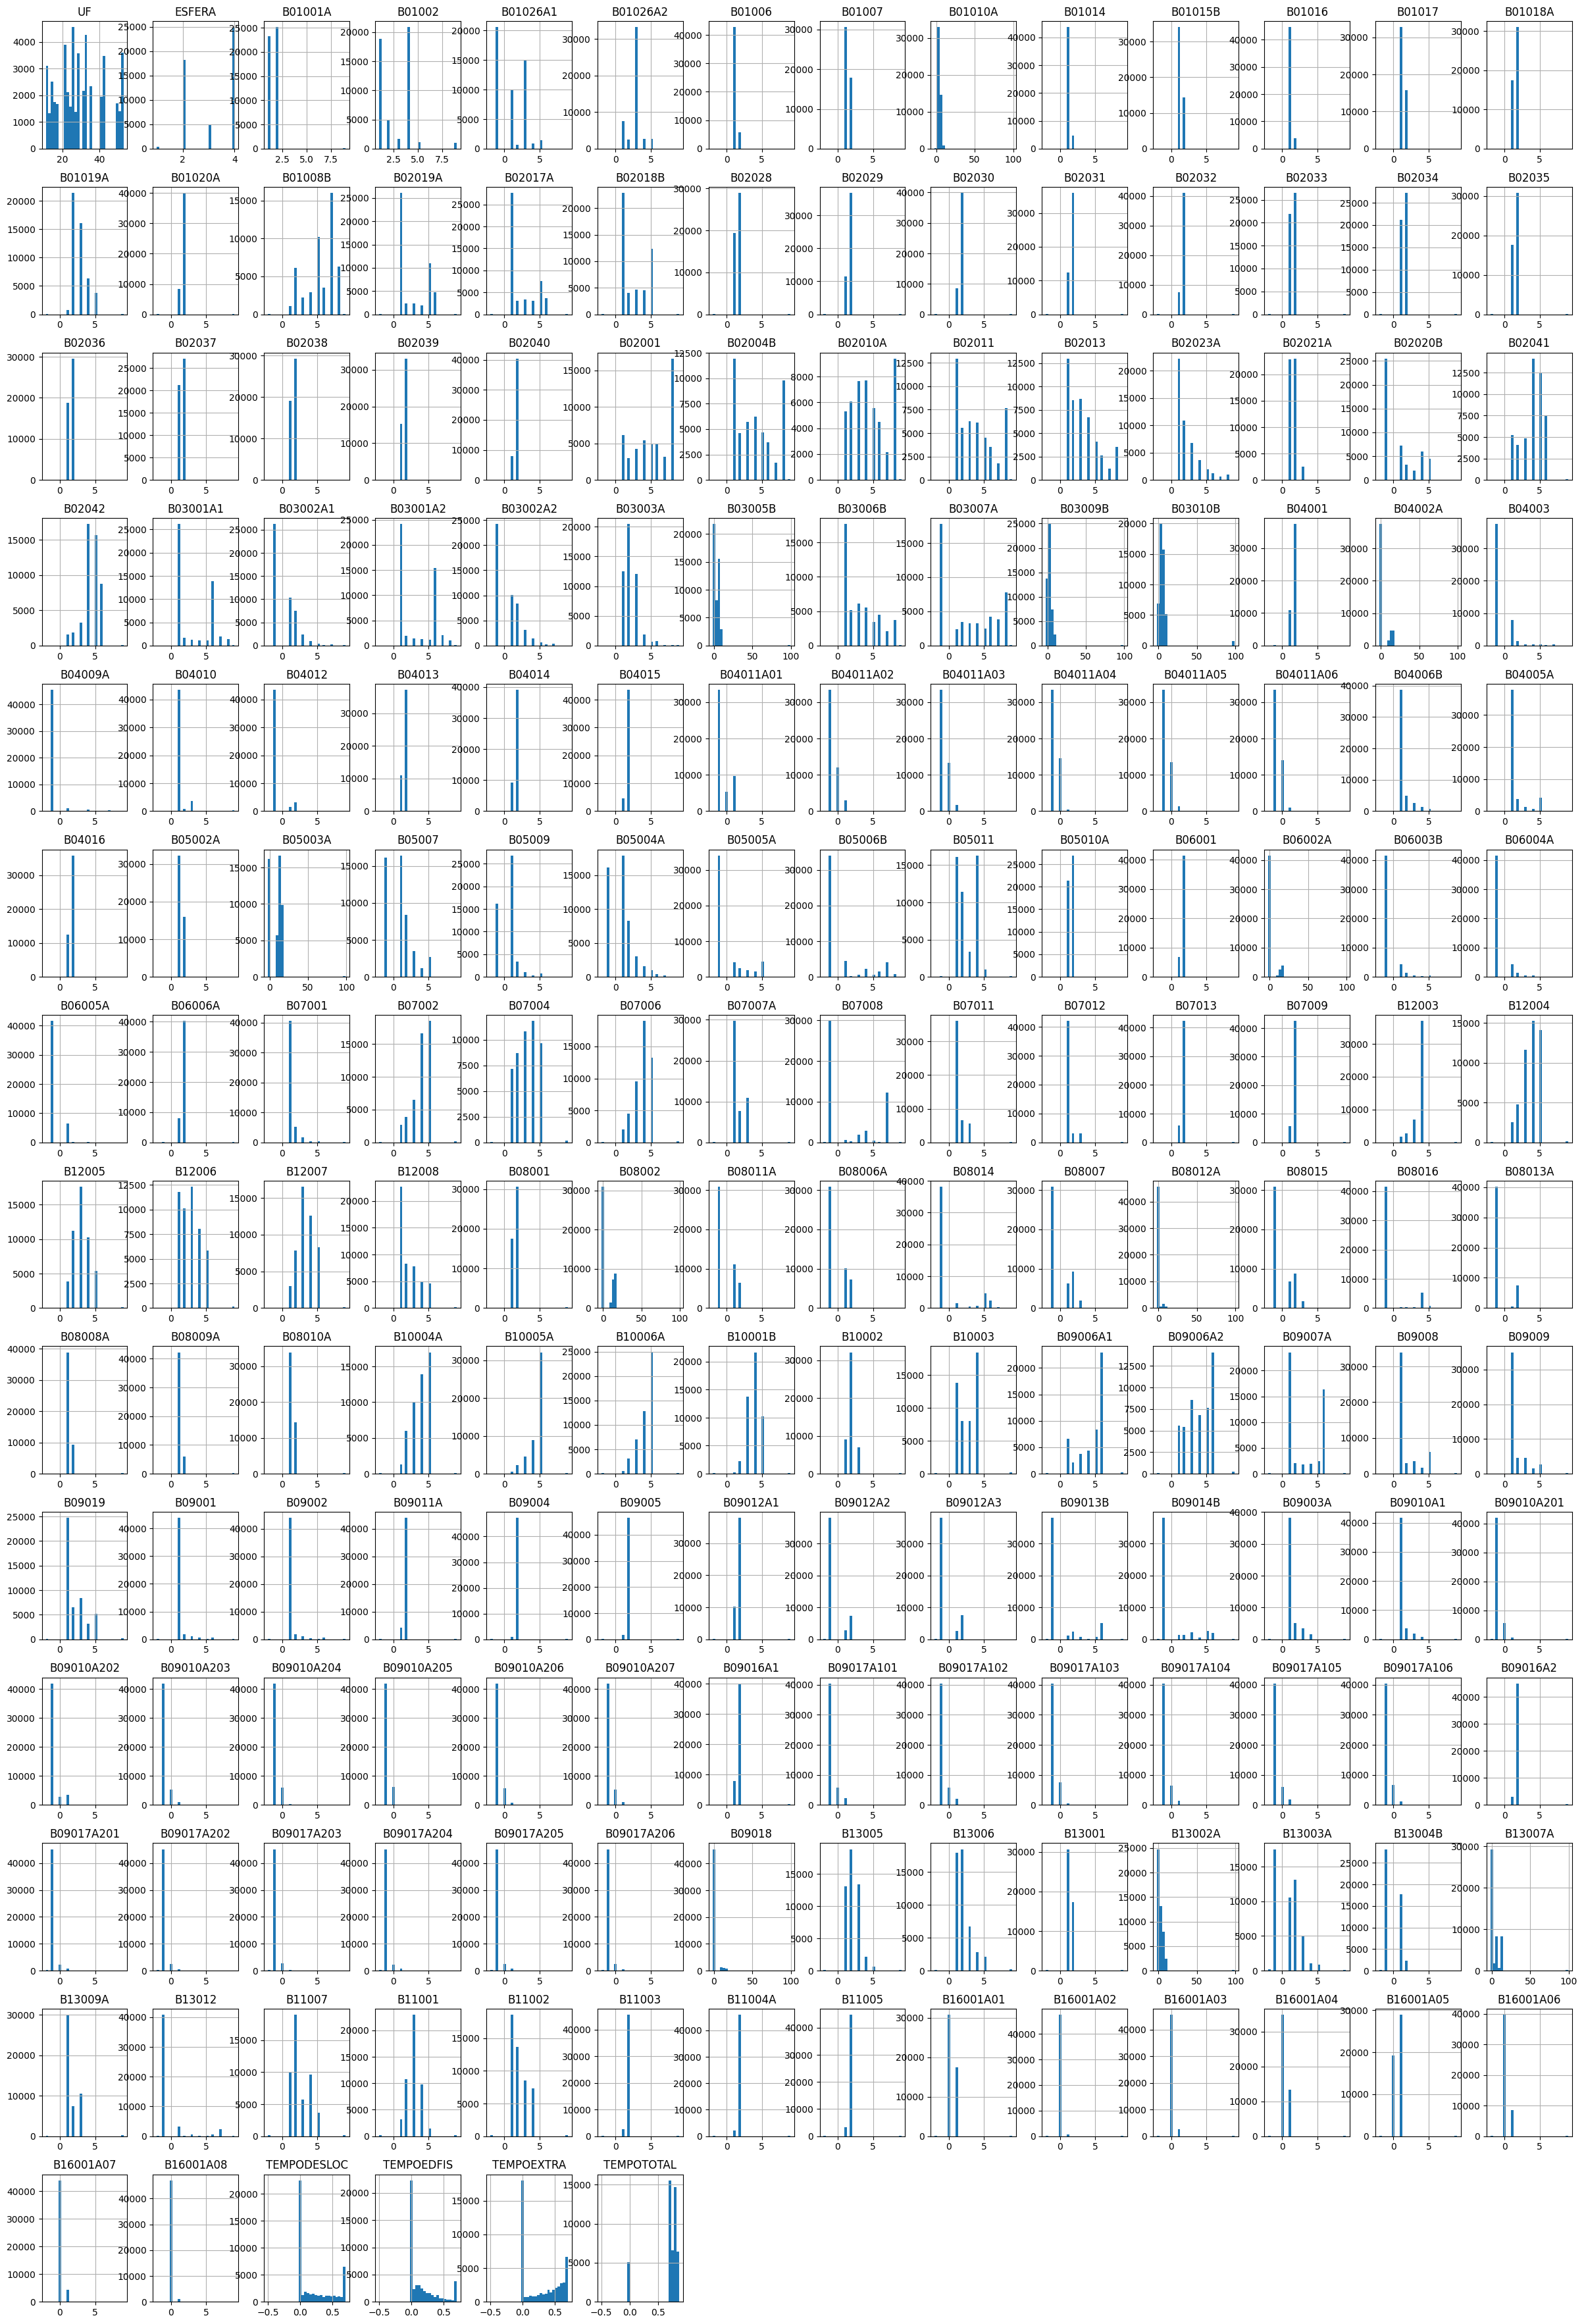

In [49]:
df.hist(figsize=(30,45),bins=30)
plt.show()

## Defining the size of "k" for Clustering

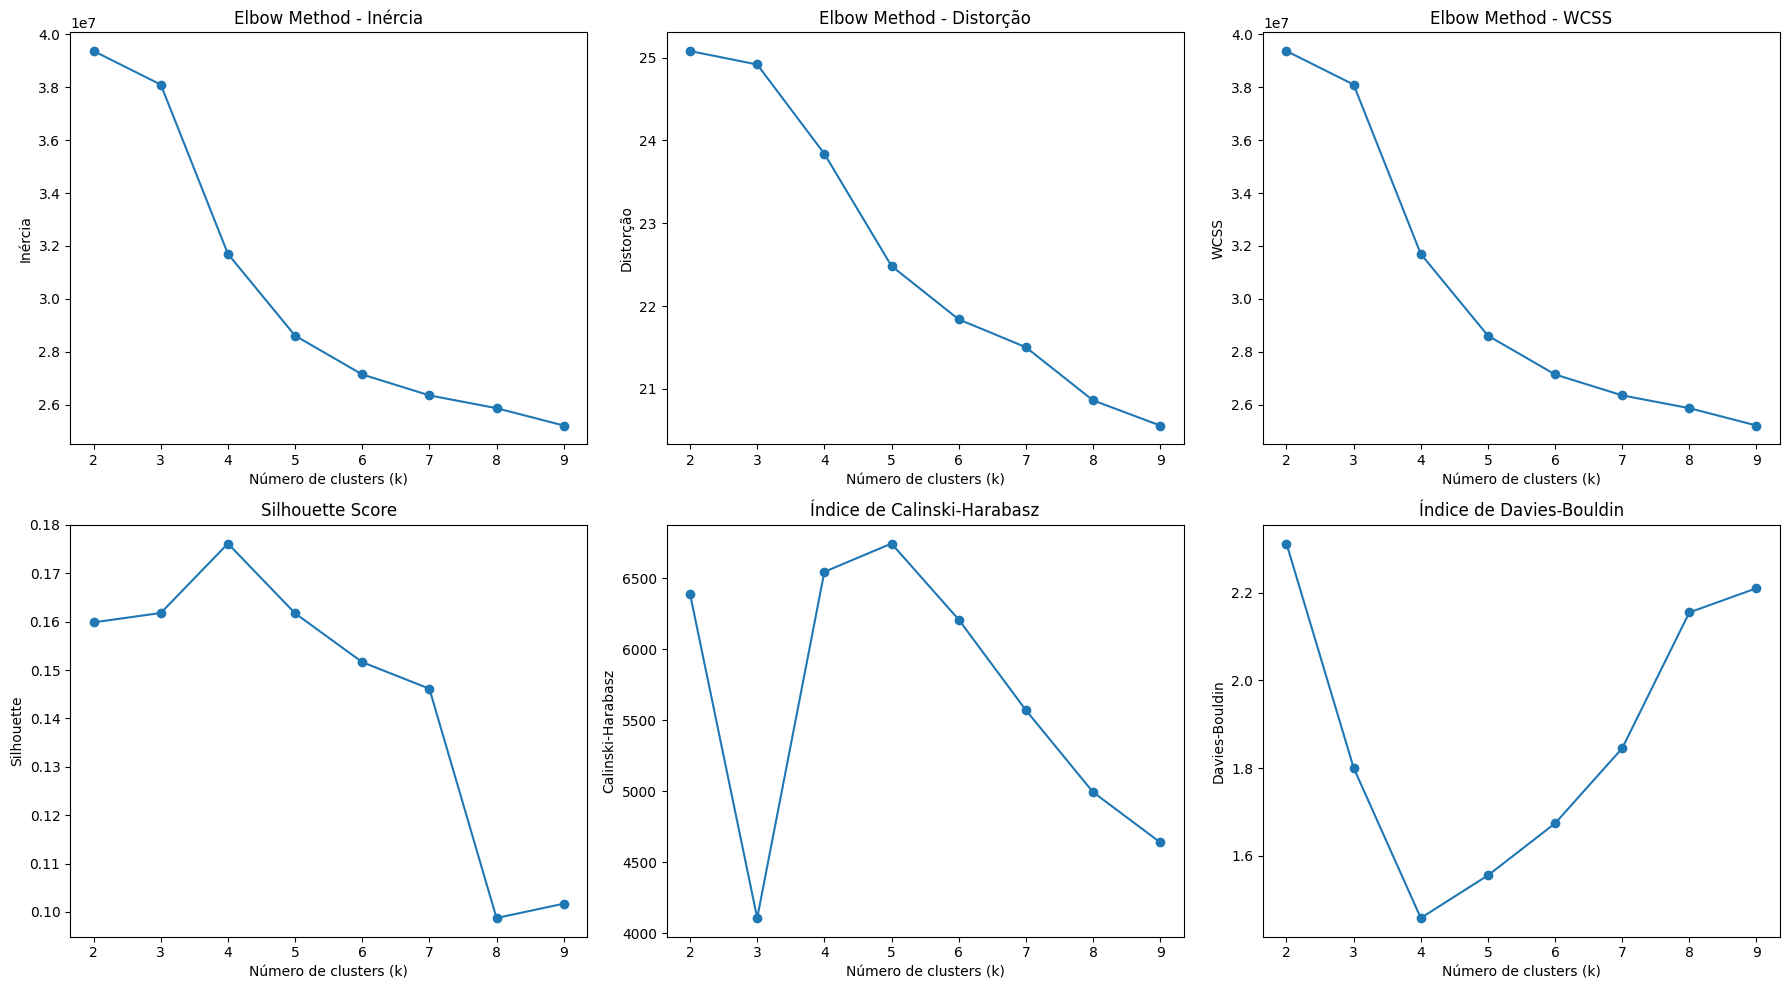

Elbow (inertia): 4
Elbow (WCSS): 4
Elbow (distorção): 5
Melhor k pelo Silhouette Score: 4
Melhor k pelo Calinski-Harabasz Index: 5
Melhor k pelo Davies-Bouldin Index: 4


In [21]:
def detect_elbow_by_max_distance(x, y):
    x_arr = np.array(x, dtype=float)
    y_arr = np.array(y, dtype=float)

    y_norm = (y_arr - y_arr.min()) / (y_arr.max() - y_arr.min())
    points = np.vstack([x_arr, y_norm]).T
    start = points[0]
    end = points[-1]

    def point_line_distance(pt, a, b):
        ba = b - a
        pa = a - pt
        cross_val = ba[0] * pa[1] - ba[1] * pa[0]
        return np.abs(cross_val) / np.linalg.norm(ba)

    distances = np.array([point_line_distance(p, start, end) for p in points])
    elbow_idx = np.argmax(distances)
    return x_arr[elbow_idx]

def detect_elbow_by_pct_change(x, y):
    y_arr = np.array(y, dtype=float)
    if len(y_arr) < 2:
        return x[0]
    deltas = np.diff(y_arr)
    pct_change = np.abs(deltas / y_arr[:-1])
    best_idx = np.argmax(pct_change) + 1
    return x[best_idx]

inertia = []
distorcao = []
wcss = []
silhouette = []
calinski = []
davies = []

K = list(range(2, 10))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)

    labels = kmeans.labels_

    inertia.append(kmeans.inertia_)
    dist = np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)
    distorcao.append(np.mean(dist))
    wcss.append(np.sum(dist**2))
    silhouette.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

best_k_inertia_elbow = detect_elbow_by_max_distance(K, inertia)
best_k_inertia_pct = detect_elbow_by_pct_change(K, inertia)

best_k_wcss_elbow = detect_elbow_by_max_distance(K, wcss)
best_k_wcss_pct = detect_elbow_by_pct_change(K, wcss)

best_k_distorcao_elbow = detect_elbow_by_max_distance(K, distorcao)
best_k_distorcao_pct = detect_elbow_by_pct_change(K, distorcao)

best_k_silhouette = K[np.argmax(silhouette)]
best_k_calinski = K[np.argmax(calinski)]
best_k_davies = K[np.argmin(davies)]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].plot(K, inertia, marker='o')
axs[0, 0].set_xlabel("Número de clusters (k)")
axs[0, 0].set_ylabel("Inércia")
axs[0, 0].set_title("Elbow Method - Inércia")

axs[0, 1].plot(K, distorcao, marker='o')
axs[0, 1].set_xlabel("Número de clusters (k)")
axs[0, 1].set_ylabel("Distorção")
axs[0, 1].set_title("Elbow Method - Distorção")

axs[0, 2].plot(K, wcss, marker='o')
axs[0, 2].set_xlabel("Número de clusters (k)")
axs[0, 2].set_ylabel("WCSS")
axs[0, 2].set_title("Elbow Method - WCSS")

axs[1, 0].plot(K, silhouette, marker='o')
axs[1, 0].set_xlabel("Número de clusters (k)")
axs[1, 0].set_ylabel("Silhouette")
axs[1, 0].set_title("Silhouette Score")

axs[1, 1].plot(K, calinski, marker='o')
axs[1, 1].set_xlabel("Número de clusters (k)")
axs[1, 1].set_ylabel("Calinski-Harabasz")
axs[1, 1].set_title("Índice de Calinski-Harabasz")

axs[1, 2].plot(K, davies, marker='o')
axs[1, 2].set_xlabel("Número de clusters (k)")
axs[1, 2].set_ylabel("Davies-Bouldin")
axs[1, 2].set_title("Índice de Davies-Bouldin")

plt.tight_layout()
plt.show()

print(f"Elbow (inertia): {best_k_inertia_pct}")
print(f"Elbow (WCSS): {best_k_wcss_pct}")
print(f"Elbow (distorção): {best_k_distorcao_pct}")
print(f"Melhor k pelo Silhouette Score: {best_k_silhouette}")
print(f"Melhor k pelo Calinski-Harabasz Index: {best_k_calinski}")
print(f"Melhor k pelo Davies-Bouldin Index: {best_k_davies}")

## Clustering

### k = 5

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(df)

df["cluster"] = labels
df.groupby("cluster").describe()

UF                                               ESFERA        \
           count   mean    std   min   25%   50%   75%   max    count  mean   
cluster                                                                       
0        21473.0  23.38   6.95  11.0  17.0  24.0  29.0  35.0  21473.0  3.30   
1         9118.0  22.32   7.16  11.0  16.0  23.0  28.0  52.0   9118.0  2.85   
2         6377.0  32.33  11.05  11.0  25.0  32.0  41.0  53.0   6377.0  2.93   
3          740.0  28.96  12.28  11.0  21.0  27.0  35.0  53.0    740.0  2.96   
4        10696.0  46.65   5.58  33.0  42.0  50.0  52.0  53.0  10696.0  3.11   

         ... TEMPOEXTRA       TEMPOTOTAL                                     \
         ...        75%   max      count  mean   std  min   25%   50%   75%   
cluster  ...                                                                  
0        ...       0.59  0.71    21473.0  0.68  0.25 -0.5  0.71  0.75  0.81   
1        ...       0.61  0.71     9118.0  0.67  0.25  0.0  0.71  0.74  0.81   
2        ...       0.59  0.71     6377.0  0.68  0.25  0.0  0.71  0.74  0.81   
3        ...       0.57  0.71      740.0  0.64  0.28  0.0  0.71  0.71  0.80   
4        ...       0.58  0.71    10696.0  0.72  0.20 -0.5  0.71  0.78  0.81   

               
          max  
cluster        
0        0.87  
1        0.87  
2        0.87  
3        0.87  
4        0.87  

[5 rows x 1504 columns]

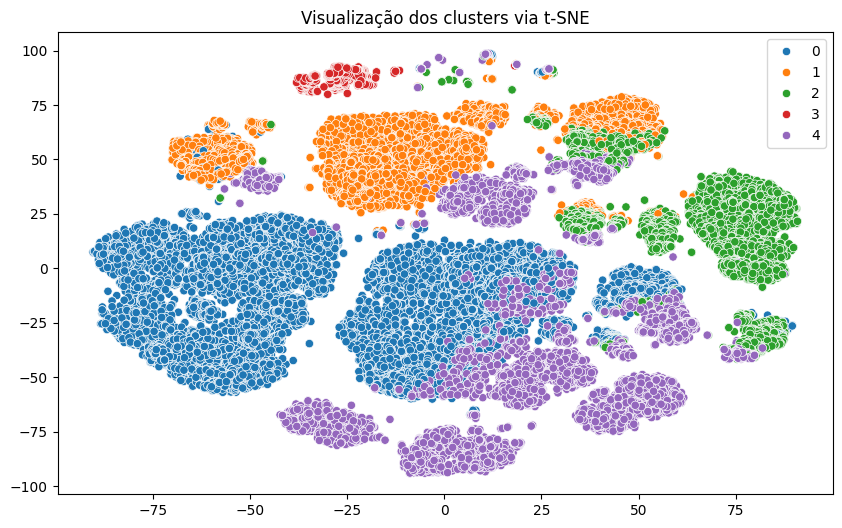

In [ ]:
X = df.values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10')
plt.title("Visualização dos clusters via t-SNE")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


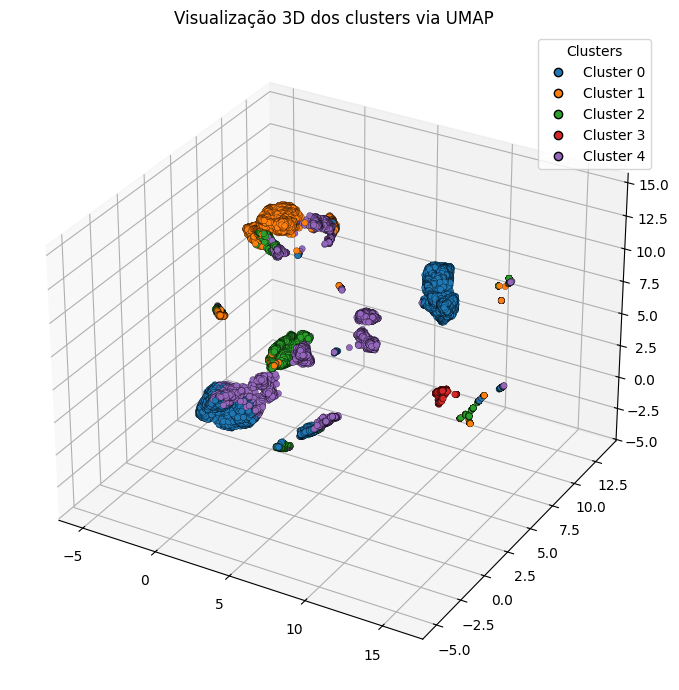

In [ ]:
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(df)


color_map = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
    3: '#d62728',  # red
    4: '#9467bd',  # purple
}

colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=colors,
    s=20,
    alpha=1.0,
    edgecolor='k',
    linewidth=0.2
)

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=color_map[i], markersize=6, markeredgecolor='k')
    for i in sorted(np.unique(labels))
]
ax.legend(handles=handles, title="Clusters")

ax.set_title("Visualização 3D dos clusters via UMAP")
plt.tight_layout()
plt.show()


### k = 4

In [50]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(df)

df["cluster"] = labels
df.groupby("cluster").describe()

UF                                               ESFERA        \
           count   mean    std   min   25%   50%   75%   max    count  mean   
cluster                                                                       
0          740.0  28.96  12.28  11.0  21.0  27.0  35.0  53.0    740.0  2.96   
1        11922.0  46.81   5.45  33.0  42.0  50.0  52.0  53.0  11922.0  3.08   
2        12918.0  24.83   8.24  11.0  17.0  25.0  31.0  52.0  12918.0  2.89   
3        22824.0  23.30   7.02  11.0  17.0  24.0  29.0  35.0  22824.0  3.28   

         ... TEMPOEXTRA       TEMPOTOTAL                                     \
         ...        75%   max      count  mean   std  min   25%   50%   75%   
cluster  ...                                                                  
0        ...       0.57  0.71      740.0  0.64  0.28  0.0  0.71  0.71  0.80   
1        ...       0.59  0.71    11922.0  0.72  0.20 -0.5  0.71  0.78  0.81   
2        ...       0.60  0.71    12918.0  0.67  0.25  0.0  0.71  0.74  0.80   
3        ...       0.59  0.71    22824.0  0.68  0.25 -0.5  0.71  0.75  0.81   

               
          max  
cluster        
0        0.87  
1        0.87  
2        0.87  
3        0.87  

[4 rows x 1504 columns]

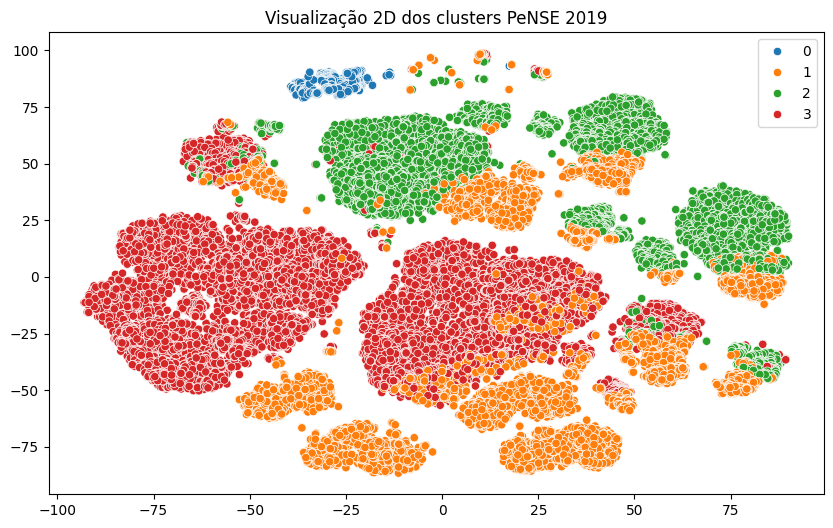

In [51]:
X = df.values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10')
plt.title("Visualização 2D dos clusters PeNSE 2019")
plt.show()

In [ ]:
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(df)

color_map = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
    3: '#d62728',  # red
}

colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=colors,
    s=20,
    alpha=1.0,
    edgecolor='k',
    linewidth=0.2
)

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=color_map[i], markersize=6, markeredgecolor='k')
    for i in sorted(np.unique(labels))
]
ax.legend(handles=handles, title="Clusters")

ax.set_title("Visualização 3D dos clusters PeNSE 2019")
plt.tight_layout()
plt.show()


## Association rules and Correlation statistics

In [ ]:
adminstrative_type_and_cod_uf_mode = df.groupby('cluster')[['ESFERA', 'UF']].agg(lambda x: x.mode().iloc[0]).reset_index()
adminstrative_type_and_cod_uf_mode

,cluster,ESFERA,UF
0,0,2.0,33
1,1,4.0,52
2,2,2.0,21
3,3,4.0,26


In [ ]:
administrative_type_and_cod_uf_dictionary = df_answers.query('Variável == "ESFERA" | Variável == "UF"')
administrative_type_and_cod_uf_dictionary

,Variável,Código,Descrição
1248,UF,11,Rondônia
1249,UF,12,Acre
1250,UF,13,Amazonas
1251,UF,14,Roraima
1252,UF,15,Para
1253,UF,16,Amapá
1254,UF,17,Tocantins
1255,UF,21,Maranhão
1256,UF,22,Piauí
1257,UF,23,Ceará


### Apriori algorithm

In [ ]:
time_columns = ["TEMPODESLOC","TEMPOEDFIS","TEMPOEXTRA","TEMPOTOTAL"]

columns_to_categorize = time_columns

for col in columns_to_categorize:
    df[col] = pd.qcut(df[col], q=3, labels=[0, 1, 2]).astype(int)

description_df = df_answers.copy()
description_df = description_df[~description_df['Variável'].isin(time_columns)]
description_df['Código'] = description_df['Código'].astype(float)
df_description_copy = description_df.copy()
categoric_df = df.copy()

mapper = {}

for _, row in df_description_copy.iterrows():
    variable = row['Variável']

    try:
        code = int(float(row['Código']))
    except (ValueError, TypeError):
        continue

    descricao = row['Descrição']

    if variable not in mapper:
        mapper[variable] = {}

    mapper[variable][code] = descricao

for column in categoric_df.columns:
    if column in mapper:
        categoric_df[column] = categoric_df[column].map(mapper[column]).fillna(categoric_df[column])


time_mapper = {0: 'Baixo', 1: 'Médio', 2: 'Alto'}


categoric_df[time_columns] = categoric_df[time_columns].replace(time_mapper)

categoric_df['IDEB'] = categoric_df['cluster'].map({0: 'Baixo', 1: 'Alto', 2: 'Médio-baixo', 3: 'Médio-alto'})

categoric_df = categoric_df.rename(columns=dict_mapper_code_description)

/tmp/ipython-input-4179778221.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categoric_df['IDEB'] = categoric_df['cluster'].map({0: 'Baixo', 1: 'Alto', 2: 'Médio-baixo', 3: 'Médio-alto'})


In [ ]:
data = categoric_df.astype(str)
transactions = data.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_binario = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(
    df_binario,
    min_support=0.25,
    use_colnames=True,
    max_len=2
)

rules = association_rules(
    frequent_itemsets,
    metric='confidence',
    min_threshold=0.75
)

apriori_rules = rules[
    (rules['lift'] > 1.5) &
    (rules['confidence'] > 0.75) &
    (rules['support'] > 0.2) &
    (rules['conviction'] > 1.2)
]


apriori_rules = apriori_rules[
    ~apriori_rules['antecedents'].astype(str).str.contains("pulo do questionário", case=False, na=False) &
    ~apriori_rules['consequents'].astype(str).str.contains("pulo do questionário", case=False, na=False)
]

apriori_rules = apriori_rules.sort_values(by=['lift', 'confidence'], ascending=False)

### Análise Estatística Correlacional

Inserting IDEB values into clusters to analyse correlation with variables

In [ ]:
numeric_df = df.copy()
numeric_df['cluster'] = numeric_df['cluster'].map({0: 3.7, 1: 6.15, 2: 4.1, 3: 5.95})

numeric_df = numeric_df.rename(columns={'cluster': 'IDEB'})

for col in numeric_df.columns:
    if not pd.api.types.is_numeric_dtype(numeric_df[col]) or col == 'IDEB':
        continue

    col_vals = numeric_df[col]

    if 99 in col_vals.values:
        numeric_df.loc[numeric_df[col] == 99, col] = np.nan
    else:
        max_val = col_vals.max()
        if max_val <= 9:
            numeric_df.loc[numeric_df[col] == max_val, col] = np.nan

    if numeric_df[col].isnull().any():
        moda = numeric_df[col].mode(dropna=True)
        if not moda.empty:
            numeric_df[col] = numeric_df[col].fillna(moda[0])

Dividing variables according their distribuition (normal or non normal)

In [ ]:
def assess_normality(series, skew_thresh=0.5, kurtosis_excess_thresh=0.5):
    s = series.dropna()
    if len(s) < 30:
        return {"approx_normal": False, "skew": np.nan, "excess_kurtosis": np.nan, "n": len(s)}
    skew = stats.skew(s)
    excess_kurtosis = stats.kurtosis(s, fisher=True)
    approx_normal = (abs(skew) <= skew_thresh) and (abs(excess_kurtosis) <= kurtosis_excess_thresh)
    return {
        "approx_normal": approx_normal,
        "skew": skew,
        "excess_kurtosis": excess_kurtosis,
        "n": len(s)
    }

def identify_normal_columns(df, skew_thresh=0.5, kurtosis_excess_thresh=0.5):
    normal = []
    non_normal = []
    details = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        res = assess_normality(df[col], skew_thresh, kurtosis_excess_thresh)
        details[col] = res
        if res["approx_normal"]:
            normal.append(col)
        else:
            non_normal.append(col)

    if "IDEB" in df.columns:
        if "IDEB" not in normal:
            normal.append("IDEB")
        if "IDEB" not in non_normal:
            non_normal.append("IDEB")
    summary_df = pd.DataFrame.from_dict(details, orient="index")
    return normal, non_normal, summary_df

normal_cols, non_normal_cols, summary_df = identify_normal_columns(numeric_df, skew_thresh=0.7, kurtosis_excess_thresh=1.0)
print("Colunas aproximadamente normais:", normal_cols)
print("Colunas não normais:", non_normal_cols)

Colunas aproximadamente normais: ['UF', 'B01026A2', 'B01008B', 'B02021A', 'B02041', 'B03006B', 'B03010B', 'B05002A', 'B05007', 'B05004A', 'B05010A', 'B12005', 'B12006', 'B12007', 'B13005', 'B13003A', 'B13009A', 'B11007', 'B11002', 'B16001A01', 'B16001A04', 'IDEB']
Colunas não normais: ['ESFERA', 'B01001A', 'B01002', 'B01026A1', 'B01006', 'B01007', 'B01010A', 'B01014', 'B01015B', 'B01016', 'B01017', 'B01018A', 'B01019A', 'B01020A', 'B02019A', 'B02017A', 'B02018B', 'B02028', 'B02029', 'B02030', 'B02031', 'B02032', 'B02033', 'B02034', 'B02035', 'B02036', 'B02037', 'B02038', 'B02039', 'B02040', 'B02001', 'B02004B', 'B02010A', 'B02011', 'B02013', 'B02023A', 'B02020B', 'B02042', 'B03001A1', 'B03002A1', 'B03001A2', 'B03002A2', 'B03003A', 'B03005B', 'B03007A', 'B03009B', 'B04001', 'B04002A', 'B04003', 'B04009A', 'B04010', 'B04012', 'B04013', 'B04014', 'B04015', 'B04011A01', 'B04011A02', 'B04011A03', 'B04011A04', 'B04011A05', 'B04011A06', 'B04006B', 'B04005A', 'B04016', 'B05003A', 'B05009', 'B0

Function to evaluate correlation results

In [ ]:
def interpret_correlation(variable, description, coef):
    abs_coef = abs(coef)
    direction = "positiva" if coef > 0 else "negativa"

    if abs_coef < 0.2:
        intensity = "muito fraca"
    elif abs_coef < 0.4:
        intensity = "fraca"
    elif abs_coef < 0.6:
        intensity = "moderada"
    elif abs_coef < 0.8:
        intensity = "forte"
    else:
        intensity = "muito forte"

    text = (
        f"A variável **{variable}** ({description}) apresenta uma correlação {direction} "
        f"{intensity} ({coef:.2%}) com o IDEB. "
    )

    if coef < 0:
        text += "Isso sugere que quanto maior o valor dessa variável, menor tende a ser o IDEB."
    else:
        text += "Isso sugere que quanto maior o valor dessa variável, maior tende a ser o IDEB."

    return text

#### Pearson

In [ ]:
corr_pearson = numeric_df[normal_cols].corr(method='pearson')
target_var = 'IDEB'

correlation_with_target_pearson = corr_pearson[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_pearson.abs().sort_values(ascending=False)

top_10_indices = ordered_correlations.index[:10]

top_10_pearson_relation = pd.DataFrame({
    'Variável': top_10_indices,
    'Correlação': correlation_with_target_pearson[top_10_indices].values
})

top_10_pearson_relation['Descrição'] = top_10_pearson_relation['Variável'].map(dict_mapper_code_description)

top_10_pearson_relation['Interpretação'] = top_10_pearson_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)

top_10_pearson_relation = top_10_pearson_relation[top_10_pearson_relation["Variável"] != "UF"]


/tmp/ipython-input-982679086.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")


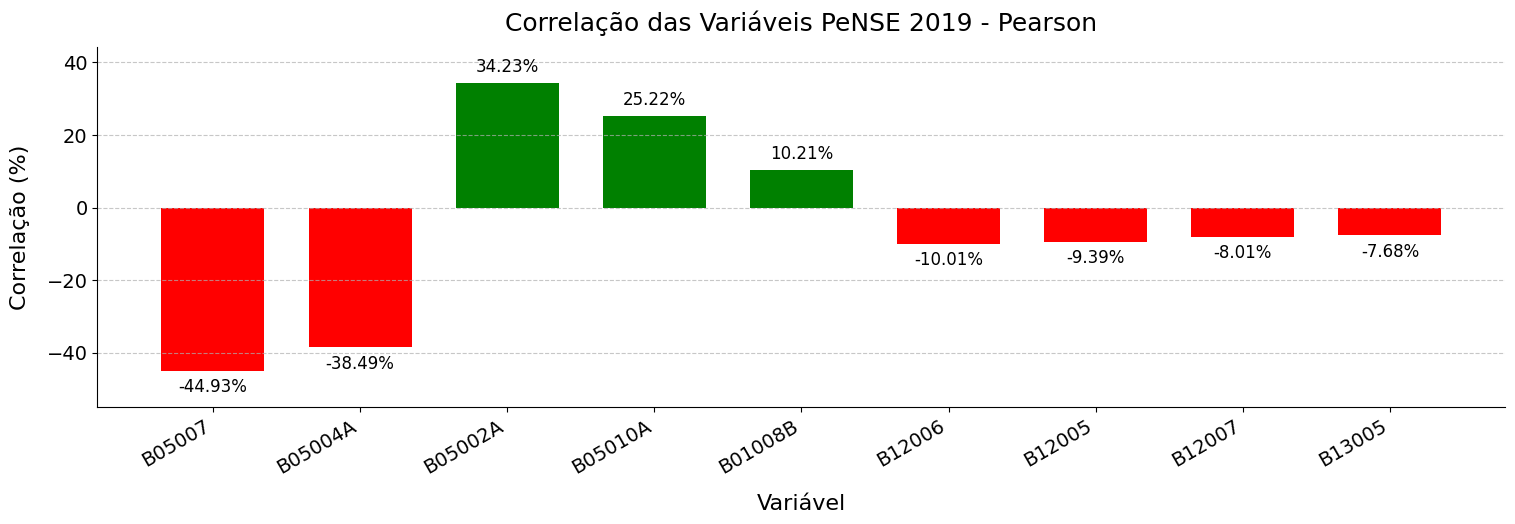

In [ ]:
top_10_pearson_relation_percentage = top_10_pearson_relation["Correlação"] * 100

fig, ax = plt.subplots(figsize=(16, 6))
bars = ax.bar(
    top_10_pearson_relation["Variável"],
    top_10_pearson_relation_percentage,
    color=["green" if x > 0 else "red" for x in top_10_pearson_relation_percentage],
    width=0.7
)

ax.set_xlabel("Variável", fontsize=16, labelpad=12)
ax.set_ylabel("Correlação (%)", fontsize=16, labelpad=12)
ax.set_title("Correlação das Variáveis PeNSE 2019 - Pearson", fontsize=18, pad=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ymin = top_10_pearson_relation_percentage.min() - 10
ymax = top_10_pearson_relation_percentage.max() + 10
ax.set_ylim(ymin, ymax)

ax.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    if height < 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height - 2,
            f"{height:.2f}%",
            ha="center",
            va="top",
            fontsize=12
        )
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 2,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=12
        )

fig.tight_layout()
fig.subplots_adjust(bottom=0.28, top=0.88, left=0.08, right=0.96)

plt.show()

#### Spearman

In [ ]:
df_encoded = numeric_df.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

cor_spearman = df_encoded[non_normal_cols].corr(method='spearman')
target_var = 'IDEB'

correlation_with_target_spearman = cor_spearman[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_spearman.abs().sort_values(ascending=False)

top_10_indices_spearman = ordered_correlations.index[:10]

top_10_spearman_relation = pd.DataFrame({
    'Variável': top_10_indices_spearman,
    'Correlação': correlation_with_target_spearman[top_10_indices_spearman].values
})


top_10_spearman_relation['Descrição'] = top_10_spearman_relation['Variável'].map(dict_mapper_code_description)


top_10_spearman_relation['Interpretação'] = top_10_spearman_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)

top_10_spearman_relation = top_10_spearman_relation[top_10_spearman_relation["Variável"] != "UF"]

/tmp/ipython-input-329798213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")


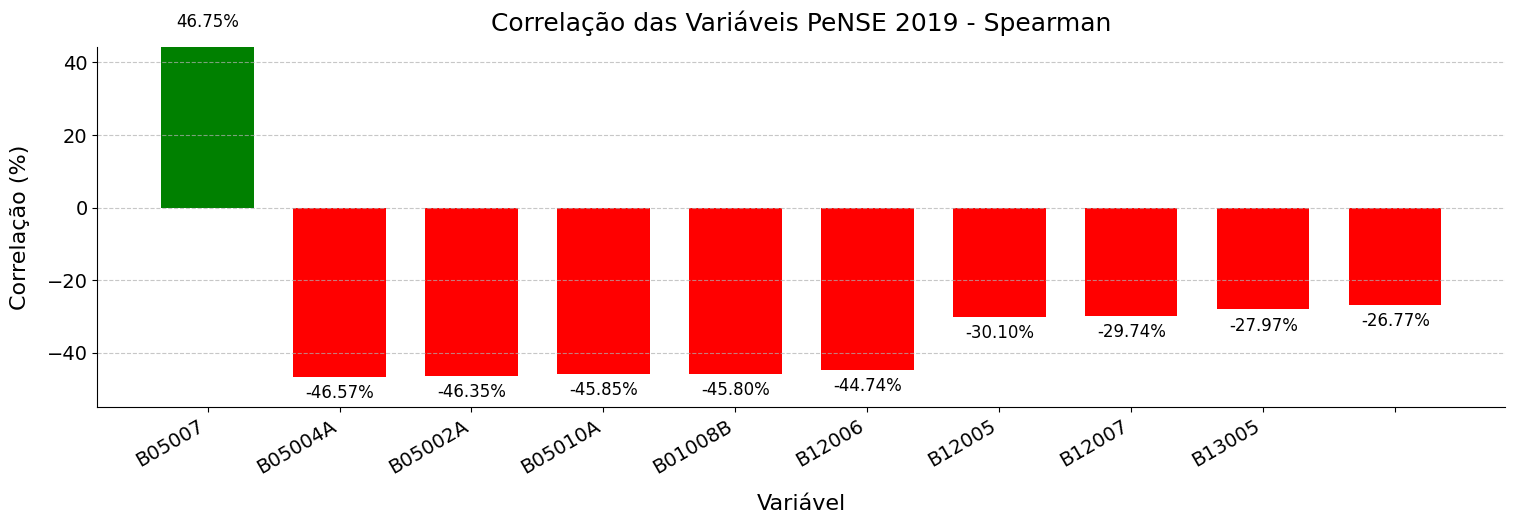

In [ ]:
top_10_spearman_relation_percentage = top_10_spearman_relation["Correlação"] * 100

fig, ax = plt.subplots(figsize=(16, 6))
bars = ax.bar(
    top_10_spearman_relation["Variável"],
    top_10_spearman_relation_percentage,
    color=["green" if x > 0 else "red" for x in top_10_spearman_relation_percentage],
    width=0.7
)


ax.set_xlabel("Variável", fontsize=16, labelpad=12)
ax.set_ylabel("Correlação (%)", fontsize=16, labelpad=12)
ax.set_title("Correlação das Variáveis PeNSE 2019 - Spearman", fontsize=18, pad=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ymin = top_10_pearson_relation_percentage.min() - 10
ymax = top_10_pearson_relation_percentage.max() + 10
ax.set_ylim(ymin, ymax)

ax.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    if height < 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height - 2,
            f"{height:.2f}%",
            ha="center",
            va="top",
            fontsize=12
        )
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 2,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=12
        )

fig.tight_layout()
fig.subplots_adjust(bottom=0.28, top=0.88, left=0.08, right=0.96)

plt.show()

#### Kendall

In [ ]:
cor_kendall = df_encoded[non_normal_cols].corr(method='kendall')
target_var = 'IDEB'

correlation_with_target_kendall = cor_kendall[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_kendall.abs().sort_values(ascending=False)

top_10_indices_kendall = ordered_correlations.index[:10]

top_10_kendall_relation = pd.DataFrame({
    'Variável': top_10_indices_kendall,
    'Correlação': correlation_with_target_kendall[top_10_indices_kendall].values
})

top_10_kendall_relation['Descrição'] = top_10_kendall_relation['Variável'].map(dict_mapper_code_description)

top_10_kendall_relation['Interpretação'] = top_10_kendall_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)


top_10_kendall_relation = top_10_kendall_relation[top_10_kendall_relation["Variável"] != "UF"]

/tmp/ipython-input-294131997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")


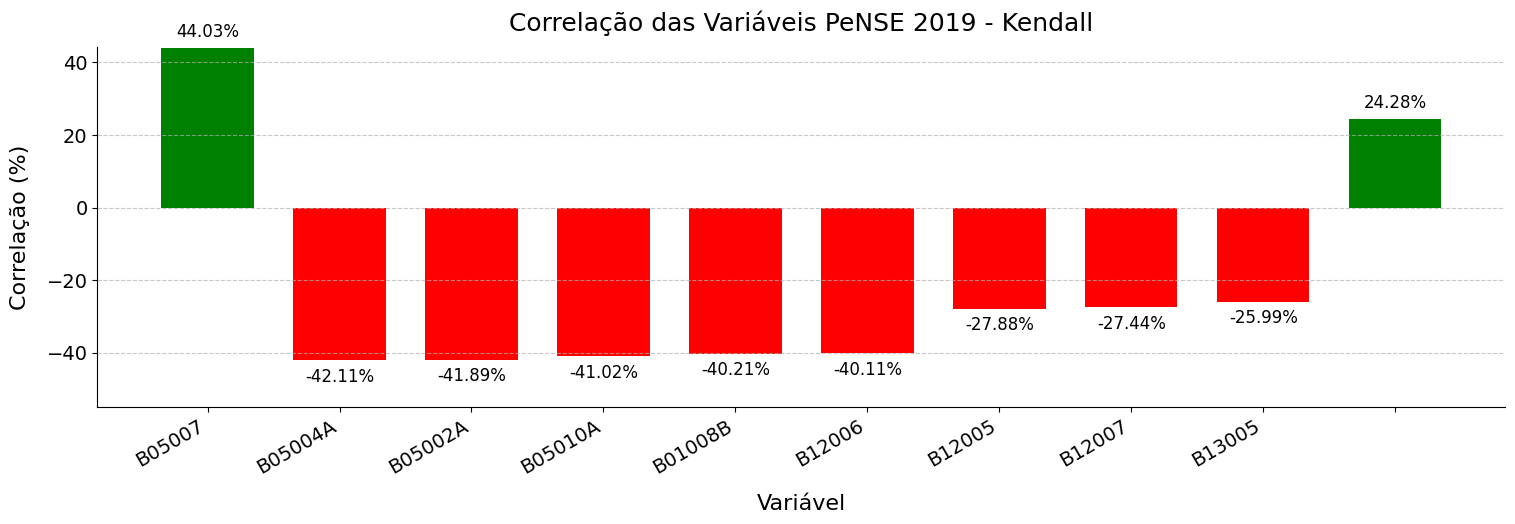

In [ ]:
top_10_kendall_relation_percentage = top_10_kendall_relation["Correlação"] * 100

fig, ax = plt.subplots(figsize=(16, 6))
bars = ax.bar(
    top_10_kendall_relation["Variável"],
    top_10_kendall_relation_percentage,
    color=["green" if x > 0 else "red" for x in top_10_kendall_relation_percentage],
    width=0.7
)

ax.set_xlabel("Variável", fontsize=16, labelpad=12)
ax.set_ylabel("Correlação (%)", fontsize=16, labelpad=12)
ax.set_title("Correlação das Variáveis PeNSE 2019 - Kendall", fontsize=18, pad=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.set_xticklabels(top_10_pearson_relation["Variável"], rotation=30, ha="right")
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ymin = top_10_pearson_relation_percentage.min() - 10
ymax = top_10_pearson_relation_percentage.max() + 10
ax.set_ylim(ymin, ymax)

ax.grid(axis="y", linestyle="--", alpha=0.7)


for bar in bars:
    height = bar.get_height()
    if height < 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height - 2,
            f"{height:.2f}%",
            ha="center",
            va="top",
            fontsize=12
        )
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 2,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=12
        )

fig.tight_layout()
fig.subplots_adjust(bottom=0.28, top=0.88, left=0.08, right=0.96)

plt.show()

## Categoric Datasets to Interpret

Creating categorical dataset with variables and answers by cluster

In [ ]:
df_without_negative_values = df.mask(df < 0)

df_with_mode_of_variables = []

for cluster_num in df_without_negative_values['cluster'].unique():
    df_cluster = df_without_negative_values[df_without_negative_values['cluster'] == cluster_num]

    df_cluster_sem_negativos = df_cluster.drop(columns=['cluster'])
    tabela_moda_cluster = pd.DataFrame({
        "Variável": df_cluster_sem_negativos.columns,
        "Valor Mais Frequente": [df_cluster_sem_negativos[col].mode().iloc[0] for col in df_cluster_sem_negativos.columns],
        "Cluster": cluster_num
    })

    df_with_mode_of_variables.append(tabela_moda_cluster)

df_with_mode_of_variables_treated = pd.concat(df_with_mode_of_variables, ignore_index=True)
df_interpretative = pd.merge(df_with_mode_of_variables_treated, dfDicionario, left_on='Variável', right_on='Código', how='left')
df_interpretative = df_interpretative[['Variável','Descrição', 'Valor Mais Frequente', 'Cluster']]
df_interpretative["Valor Mais Frequente"] = df_interpretative["Valor Mais Frequente"].apply(lambda x: str(int(x)) if isinstance(x, (int, float)) and x.is_integer() else str(x))
df_interpretative['CONCAT'] = df_interpretative['Variável'].astype(str) + df_interpretative['Valor Mais Frequente'].astype(str)
df_answers['CONCAT'] = df_answers['Variável'].astype(str) + df_answers['Código'].astype(str)
df_interpretative = df_interpretative.merge(df_answers[["CONCAT", "Descrição"]], on="CONCAT", how="left", suffixes=("", "_t2"))
df_interpretative["Valor Mais Frequente"] = df_interpretative["Descrição_t2"]
df_interpretative.drop(columns=["Descrição_t2"], inplace=True)


Associating IDEB values to dataset

In [ ]:
ideb_map = {
    "Rio de Janeiro": 3.7,
    "Goiás": 6.15,
    "Maranhão": 4.10,
    "Pernambuco": 5.95,
}

state_by_cluster = df_interpretative[df_interpretative['Variável'] == 'UF'].set_index('Cluster')['Valor Mais Frequente'].to_dict()

df_interpretative['IDEB'] = df_interpretative['Cluster'].map(state_by_cluster).map(ideb_map)



Creating dataset with only divergent variables

In [ ]:
df_differences_items = df_interpretative.groupby('Variável')['Valor Mais Frequente'].nunique()
variables_with_diference = df_differences_items[df_differences_items > 1].index

df_with_only_different_values_by_varibles = df_interpretative[df_interpretative['Variável'].isin(variables_with_diference)].sort_values(['Variável', 'Cluster'])

## Download Section

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"PeNSE2019_analise_completa_{timestamp}.xlsx"

with pd.ExcelWriter(filename) as writer:
    df_interpretative.to_excel(writer, sheet_name='Clusterizacao_Completa', index=False)
    df_with_only_different_values_by_varibles.to_excel(writer, sheet_name='Diferencas_Clusters', index=False)
    top_10_spearman_relation.to_excel(writer, sheet_name='Spearman', index=False)
    top_10_pearson_relation.to_excel(writer, sheet_name='Pearson', index=False)
    top_10_kendall_relation.to_excel(writer, sheet_name='Kendal', index=False)
    apriori_rules.to_excel(writer, sheet_name='Regras_Associacao', index=False)
    df_answers.to_excel(writer, sheet_name='Dicionario', index=False)

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>